In [ ]:
#@title imports & setup
import os, re, sys, random
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

In [ ]:
#@title load label dataframe (googlesheet/csv)
sheet_url = "/content/drive/MyDrive/Courses/Phy188 Final Project/img_data/All_Aurora_Data_Classified - Sheet1.csv"
labels_df = pd.read_csv(sheet_url)

labels_df["Date"] = labels_df["Date"].astype(str)
labels_df["Number"] = labels_df["Number"].astype(str)
labels_df['Observatory'] = labels_df['Observatory'].str.lower()

print(labels_df.head())

#train/test labels on the df
train_df, test_df = train_test_split(
    labels_df,
    test_size=0.3,
    random_state=42,
    stratify=labels_df["Class"]
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

#transform images
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

       Date Observatory Number  Class  Unnamed: 4 classification  num
0  20240510        luck      0      0         NaN           moon  0.0
1  20240510        luck      1      0         NaN            arc  1.0
2  20240510        luck      2      0         NaN       discrete  2.0
3  20240510        luck      3      0         NaN        diffuse  3.0
4  20240510        luck      4      0         NaN         cloudy  4.0
Train size: 1470
Test size: 630


In [ ]:
#@title function to load images with class labels from df
import os
import re
import numpy as np
from PIL import Image

def load_images_from_df(root_folder, df, transform=None):

    #Load images given a DataFrame containing Date, Observatory, Number, Class.
    #Handles diff values of zero-padding in filenames (ex. 000245, 0000034).
    images = []
    labels = []

    for idx, row in df.iterrows():
        date = row["Date"]
        observatory = row["Observatory"]
        number = str(row["Number"])
        label = row["Class"]

        # Construct folder path
        folder_path = os.path.join(root_folder, f"data_{date}")
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist, skipping")
            continue

        #regex to match any number of digits
        pattern = re.compile(rf"{observatory}_frame_0*{number}\.png")

        #Search for a matching file in the folder
        matched_files = [f for f in os.listdir(folder_path) if pattern.fullmatch(f)]
        if not matched_files:
            print(f"Warning: No matching file for {observatory} {number} in {folder_path}")
            continue

        #load the first match
        img_path = os.path.join(folder_path, matched_files[0])
        try:
            img = Image.open(img_path).convert("RGB")
            if transform:
                img = transform(img)
            else:
                img = np.array(img, dtype=np.float32) / 255.0  # normalize 0-1
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Warning: Failed to load {img_path}: {e}")
            continue

    if len(images) == 0:
        raise RuntimeError("No images loaded :()")

    return np.stack(images), np.array(labels)

In [ ]:
#@title making train and test datasets
root_folder = "/content/drive/MyDrive/Courses/Phy188 Final Project/img_data"

#train and test data
x_tr, y_tr = load_images_from_df(root_folder, train_df, transform)
x_te, y_te = load_images_from_df(root_folder, test_df, transform)

print(x_tr.shape, y_tr.shape)
print(x_te.shape, y_te.shape)

#Convert to PyTorch tensors
device = 'cuda' if th.cuda.is_available() else 'cpu'
x_tr = th.tensor(x_tr, dtype=th.float32).to(device)
y_tr = th.tensor(y_tr, dtype=th.long).to(device)
x_te = th.tensor(x_te, dtype=th.float32).to(device)
y_te = th.tensor(y_te, dtype=th.long).to(device)

#check size
print(f"Train images: {x_tr.shape}, Train labels: {y_tr.shape}")
print(f"Test images: {x_te.shape}, Test labels: {y_te.shape}")

(1470, 3, 128, 128) (1470,)
(630, 3, 128, 128) (630,)
Train images: torch.Size([1470, 3, 128, 128]), Train labels: torch.Size([1470])
Test images: torch.Size([630, 3, 128, 128]), Test labels: torch.Size([630])


In [ ]:
#@title Do Grayscaling

def rgb_to_grayscale(x):
    gray = 0.2989*x[:,0] + 0.5870*x[:,1] + 0.1140*x[:,2]
    return gray.unsqueeze(1).repeat(1,3,1,1)

#grayscale training and test datasets
x_tr_gray = rgb_to_grayscale(x_tr)
x_te_gray = rgb_to_grayscale(x_te)

#normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

mean = th.tensor(imagenet_mean, device=device).view(1,3,1,1)
std  = th.tensor(imagenet_std, device=device).view(1,3,1,1)

x_tr_gray = (x_tr_gray - mean)/std
x_te_gray = (x_te_gray - mean)/std

In [ ]:
#@title Optimized ResNet-18 Training

#Parameters (reduced runtim)
N = 1
batch_size_tr = 32
batch_size_te = 32
epochs = 15
lr = 1e-3 #standard

#Datasets & loaders
train_ds = TensorDataset(x_tr_gray, y_tr)
test_ds  = TensorDataset(x_te_gray, y_te)

train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size_te, shuffle=False, num_workers=2)

#Weighted loss (addressing class imbalance)
class_counts = np.bincount(y_tr.cpu().numpy(), minlength=len(classes))
weights = np.zeros_like(class_counts, dtype=np.float32)
nonzero = class_counts > 0
weights[nonzero] = 1.0 /class_counts[nonzero]
weights = weights /weights.sum() * len(classes)

criterion = nn.CrossEntropyLoss(weight=th.tensor(weights, device=device, dtype=th.float))

#Storage for metrics
y_true = y_te.cpu().numpy()
y_pred = np.zeros((N, len(y_true)), dtype=np.int32)
scores = []

#Training loop
for n in range(N):
    #Pretrained ResNet-18
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
    #Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    #Unfreeze last block+fc
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True

    #Replace final layer
    model.fc = nn.Linear(512, len(classes)).to(device)

    optimizer = th.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    for epoch in range(epochs):
        model.train()
        losses = []

        for x_b, y_b in train_loader:
            optimizer.zero_grad()
            out = model(x_b)
            loss = criterion(out, y_b)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        #Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with th.no_grad():
            for x_b, y_b in test_loader:
                out = model(x_b)
                preds = out.argmax(1)
                correct += (preds == y_b).sum().item()
                total += y_b.size(0)
        acc = correct / total
        print(f"Run {n} | Epoch {epoch+1}/{epochs} | Loss {np.mean(losses):.4f} | Accuracy {acc:.4f}")

    #store predictions
    model.eval()
    preds_list = []
    with th.no_grad():
        for x_b, _ in test_loader:
            out = model(x_b)
            preds_list.append(out.argmax(1).cpu())
    y_pred[n] = th.cat(preds_list).numpy()

    #Store macro metrics
    scores.append([score(y_true, y_pred[n], average="macro", zero_division=0)])

#Final metrics:
final_scores = np.array(scores, dtype=np.float32)[:, 0, :3]
print("Precision | Recall | F1")
print(final_scores)
print("Mean:", final_scores.mean(0))
print("Std:", final_scores.std(0))


Run 0 | Epoch 1/15 | Loss 0.9364 | Accuracy 0.7063
Run 0 | Epoch 2/15 | Loss 0.5017 | Accuracy 0.7905
Run 0 | Epoch 3/15 | Loss 0.4033 | Accuracy 0.8206
Run 0 | Epoch 4/15 | Loss 0.2920 | Accuracy 0.7667
Run 0 | Epoch 5/15 | Loss 0.2502 | Accuracy 0.8492
Run 0 | Epoch 6/15 | Loss 0.1579 | Accuracy 0.8349
Run 0 | Epoch 7/15 | Loss 0.1368 | Accuracy 0.8603
Run 0 | Epoch 8/15 | Loss 0.1674 | Accuracy 0.7984
Run 0 | Epoch 9/15 | Loss 0.1668 | Accuracy 0.8190
Run 0 | Epoch 10/15 | Loss 0.1637 | Accuracy 0.8556
Run 0 | Epoch 11/15 | Loss 0.0930 | Accuracy 0.8587
Run 0 | Epoch 12/15 | Loss 0.0611 | Accuracy 0.8730
Run 0 | Epoch 13/15 | Loss 0.0765 | Accuracy 0.8730
Run 0 | Epoch 14/15 | Loss 0.0815 | Accuracy 0.8508
Run 0 | Epoch 15/15 | Loss 0.0946 | Accuracy 0.8460
Precision | Recall | F1
[[0.8737508 0.9124403 0.8874803]]
Mean: [0.8737508 0.9124403 0.8874803]
Std: [0. 0. 0.]


In [ ]:
#put back colors

#x_te: (N, 3, H, W), values 0-1
x_te_np = x_te.cpu().numpy()  #(N, 3, H, W)
brightness = x_te_np.mean(axis=1)  #(N, H, W)
mask = brightness > 0.05          #ignore very dark pixels

#Compute masked mean w/o black
r = np.array([img[0][m].mean() if m.any() else 0 for img, m in zip(x_te_np, mask)])
g = np.array([img[1][m].mean() if m.any() else 0 for img, m in zip(x_te_np, mask)])
b = np.array([img[2][m].mean() if m.any() else 0 for img, m in zip(x_te_np, mask)])

#normalization
#eps = 1e-6
#rgb_sum = r + g + b + eps
#r_norm = r / rgb_sum
#g_norm = g / rgb_sum
#b_norm = b / rgb_sum

#assign color labels (dominant color)
def label_aurora_color(r, g, b):
    colors = np.array([r, g, b])
    max_idx = colors.argmax()
    if max_idx == 0:
        return "red"
    elif max_idx == 1:
        return "green"
    else:
        return "purple"
color_labels = [label_aurora_color(r[i], g[i], b[i]) for i in range(len(r))]

#dataframe
df = pd.DataFrame({
    "true_class": y_te.cpu().numpy(),
    "pred_class": y_pred[0],
    "aurora_color": color_labels,
    "r": r,
    "g": g,
    "b": b
})

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

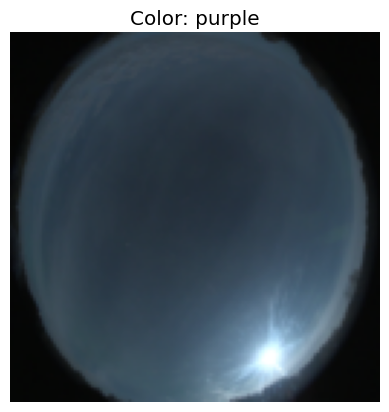

In [ ]:
#@title CHECK: color labels
idx = np.random.randint(len(x_te))
img = x_te[idx].cpu().numpy().transpose(1, 2, 0)
plt.imshow(img / img.max())
plt.title(f"Color: {color_labels[idx]}")
plt.axis("off")

In [ ]:
#CHECK: Count number of images per aurora color
color_counts = df['aurora_color'].value_counts()
print(color_counts)

aurora_color
green     322
purple    216
red        92
Name: count, dtype: int64


In [ ]:
#@title color distr per aurora class
color_disr = pd.crosstab(df["pred_class"],df["aurora_color"],normalize="index")
print(color_disr)

aurora_color     green    purple       red
pred_class                                
0             0.000000  1.000000  0.000000
1             0.730769  0.230769  0.038462
2             0.581152  0.204188  0.214660
3             0.449511  0.390879  0.159609
4             0.555556  0.444444  0.000000
5             0.531915  0.468085  0.000000


/tmp/ipython-input-3307018911.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_color = df.groupby("aurora_color").apply(lambda x: (x.true_class == x.pred_class).mean())


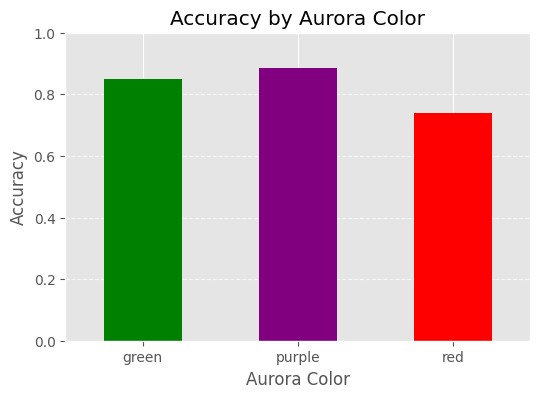

In [ ]:
#@title accuracies based on colored auroras
acc_by_color = df.groupby("aurora_color").apply(lambda x: (x.true_class == x.pred_class).mean())

#color map keyed by label
color_map = {"green": "green", "red": "red", "purple": "purple"}

#color list in same order as index
bar_colors = acc_by_color.index.map(color_map)

#plotting
plt.figure(figsize=(6,4))
acc_by_color.plot(kind='bar', color=bar_colors)

plt.title("Accuracy by Aurora Color")
plt.ylabel("Accuracy")
plt.xlabel("Aurora Color")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

VISUALIZATIONS

<Figure size 1000x600 with 0 Axes>

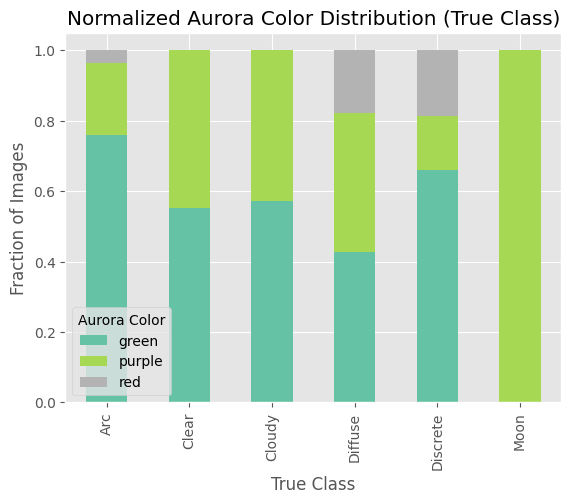

In [ ]:
#@title Distribution of colors per true class

#Map integer labels to class names
df['true_class_name'] = df['true_class'].map(lambda x: classes[x])

#Distribution of colors per true class
class_color_dist = pd.crosstab(df['true_class_name'], df['aurora_color'], normalize='index')
#Plotting
plt.figure(figsize=(10,6))
class_color_dist.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Normalized Aurora Color Distribution (True Class)")
plt.ylabel("Fraction of Images")
plt.xlabel("True Class")
plt.legend(title="Aurora Color")
plt.show()


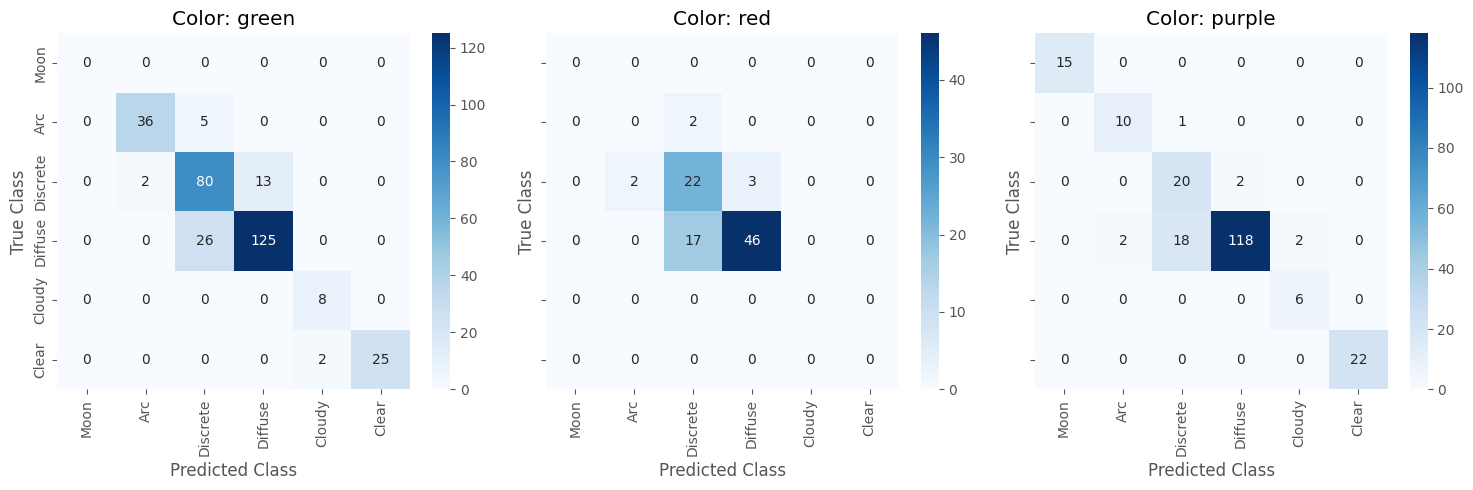

In [ ]:
#@title confusion matrices for each color
import seaborn as sns
from sklearn.metrics import confusion_matrix

colors = df['aurora_color'].unique()

#Determine subplot grid size
n_colors = len(colors)
fig, axes = plt.subplots(1, n_colors, figsize=(5*n_colors, 5), sharey=True)

if n_colors == 1:  #single color
    axes = [axes]

for ax, color in zip(axes, colors):
    #only images of this color
    df_color = df[df['aurora_color'] == color]
    y_true = df_color['true_class']
    y_pred = df_color['pred_class']

    #cm
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

    #heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f"Color: {color}")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("True Class")

plt.tight_layout()
plt.show()